
# Table of Contents

* Introduction
* Dataset
* The Neural Network
  * Super Resolution
  * Variational Auto Encoder
  * VAE_SR
* Training Loop
* Analysis

# Introduction

In recent years, generative models have revolutionized the way we generate visual data. Among these, <span style="color: orange; font-weight:bold;">Variational Autoencoders</span> stand out due to their simplicity relative to more state of the art models such as diffusion or GANs,  while still having the  ability to learn complex distributions and generate images.

<span style="color: #45cc77; font-weight:bold;">Problem:</span> <br>
I wanted to experiment with a VAE’s ability to generate new images from a learned dataset, but due to GPU limitations I needed to make compromises to improve efficiency:<br>
* To achieve faster convergence, I needed an image dataset with minimal variation.<br>
* To optimize memory usage, the data size had to be as small as possible.<br>

<span style="color: #45cc77; font-weight:bold;">Solution:</span> <br>
I constructed my dataset from the frames of a 30-second time-lapse video of moving clouds that I recorded a few years ago, and it turned out to be a perfect fit.<br>
* The camera is stationary and points to the sky, so relatively minimal variation across the "background" of the clouds<br>
* Instead of using a simple VAE, I combined a VAE with a super-resolution model to reduce the input data resolution. My model will learn on 18 x 32 images and output images at a resolution of 72 x 128.

<span style="color: #45cc77; font-weight:bold;">Result:</span> <br>
After only 6 minutes of training I managed to generate a video of fake clouds in 72 x 128 resolution


In [1]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim import Adam
from tqdm import tqdm
from IPython.display import HTML
from matplotlib import animation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cuda


# Dataset

First, let's define a function to render an image from its tensor form. This will make it easier to explore and interpret the visual data.

In [2]:
def render_image(img, title='', portrait_mode=False):
  img = (img + 1) / 2
  img = img.cpu()
  img = np.transpose(img,  (1, 2, 0))
  if portrait_mode:
    img = torch.rot90(img.unsqueeze(0), k=3, dims=[1, 2]).squeeze()

  plt.figure(figsize=(3, 3), tight_layout=True)
  plt.imshow(img)
  plt.title(title, fontsize=18, weight='bold')
  plt.axis('off')
  plt.show()

Now let's define a class for our image dataset.<br/>
when initialized, it will load a video, extract it's frames and turn them into Data (X) and Labels (y) tensors, compatible with our network

In [3]:

class VideoDataset(Dataset):
    def __init__(self, video_path, max_size, ratio, portrait_mode):
        self.video_path = video_path
        self.portrait_mode = portrait_mode
        self.max_size = max_size
        self.ratio = ratio
        self._load_video_frames()

    def _load_video_frames(self):
        # Open the video file
        cap = cv2.VideoCapture(self.video_path)
        X_gt = []
        y_gt = []

        print('Video loaded:', cap.isOpened())
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            tr_size = (2, 1, 0) if self.portrait_mode else (2, 0, 1)

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = torch.from_numpy(frame).float().permute(tr_size) / 255.0
            img_shape = torch.tensor(frame.shape)[1:].numpy()

            normalized_shape = (self.max_size * (img_shape / np.max(img_shape)))
            small_shape = (normalized_shape/self.ratio)
            small_shape = (int(small_shape[0]), int(small_shape[1]))
            
            normalized_shape = (int(small_shape[0] * self.ratio), int(small_shape[1] * self.ratio))

            X_tr = transforms.Compose([
              transforms.Resize(small_shape)
            ])
            X_frame = X_tr(frame)
            X_gt.append(X_frame.numpy())

            y_tr = transforms.Compose([
              transforms.Resize(normalized_shape)
            ])
            y_frame = y_tr(frame)
            y_gt.append(y_frame.numpy())

        cap.release()

        def normalize(t):
            t = torch.tensor(t)
            # [0 ~ 1]
            t -= torch.min(t)
            t /= torch.max(t)

            # [-1 ~ 1]
            t *= 2
            t -= 1
            return t
        self.X_gt = normalize(X_gt)
        self.y_gt = normalize(y_gt)

    def __len__(self):
        return len(self.X_gt)

    def __getitem__(self, idx):
        return self.X_gt[idx], self.y_gt[idx]


and another function to turn frames back into video

In [4]:
def create_video(frames, transform=True, portrait_mode=False):
  if transform:
    frames = np.transpose(frames, (0, 2, 3, 1))
  if portrait_mode:
    frames = np.rot90(frames, k=3, axes=(1, 2))

  print('Video shape:', np.array(frames).shape)
  fig = plt.figure()
  plt.axis('off')
  im = plt.imshow(frames[0])
  plt.close() # this is required to not display the generated image
  def init():
      im.set_data(frames[0])

  def animate(i):
      im.set_data(frames[i])
      return im

  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames.shape[0], interval=100)
  return HTML(anim.to_html5_video())

Time to load the data and sample an example

Video loaded: True
Video dataset length 1790


Training data size: torch.Size([3, 18, 32])


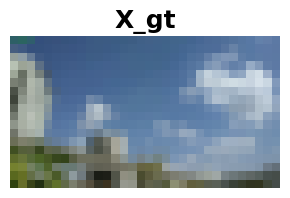



Ground truth size: torch.Size([3, 72, 128])


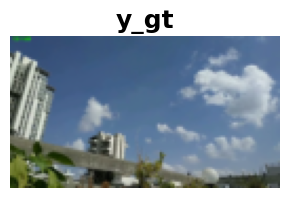



200 frames sample of the original video:
Video shape: (200, 72, 128, 3)


In [ ]:

vid_p = '/home/roman/Desktop/ML/Datasets/videos/clouds.mp4'

portrait_mode = False

gen_image_size = 128
ds = VideoDataset(vid_p, gen_image_size, 4, portrait_mode)
print('Video dataset length', len(ds))

X_gt = ds.X_gt
y_gt = ds.y_gt

test_index = 50
test_image = X_gt[test_index].to(device)
test_target = y_gt[test_index].to(device)

print("\n\nTraining data size:", test_image.shape)
render_image(test_image, 'X_gt', portrait_mode=portrait_mode)
print("\n\nGround truth size:", test_target.shape)
render_image(test_target, 'y_gt', portrait_mode=portrait_mode)

print("\n\n200 frames sample of the original video:")
sample = y_gt[100:300]
sample -= torch.min(sample)
sample /= torch.max(sample)
create_video(sample)


And finally we initialize the dataloader

In [6]:
batch_size = 32
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

# The Neural Network

There are 2 main goals here:
1. Train the network to take a small pixelated image and produce a clearer image 4 times in size.
2. Explore what and how well it has managed to learn



##Super Resolution



For the first part, we'll need to use an enhancing model (super - resolution) that will generate an image 4 times the resolution of the input image

In [7]:
class SuperResolution(nn.Module):
    def __init__(self):
        super(SuperResolution, self).__init__()
        
        # Initial convolution layers to extract features
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Upsampling layers
        # First upsampling layer: scales by 2x
        self.deconv1 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1)
        # Second upsampling layer: scales by another 2x (total 4x)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        
        # Final convolution to reduce channels to the output (3 for RGB)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        
        # Activation functions
        self.relu = nn.LeakyReLU(negative_slope=0.2)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Initial feature extraction
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        # Upsampling
        x = self.relu(self.deconv1(x))  # 2x upscaling
        x = self.relu(self.deconv2(x))  # 2x upscaling (total 4x)
        
        # Output layer
        x = self.tanh(self.final_conv(x))
        
        return x

## Variational Auto Encoder

For the second part we'll use an Auto-Encoder architecture, which consists of an Encoder stage and a Decoder stage.<br>
The encoder maps the input data a vector space called "latent space", and the decoder maps latent vectors to an actual image.

The auto encoder will learn to map each image to a latent vector in a certain distribution. we would want to control this distribution so that we could sample it later.<br>

in order to have control over this distribution we'll define variables for Mean and Variance that the model will learn, and give certain restrictions to it later during training so it doesn't diverge<br>

An autoencoder with the addition of these parameters is called a "**Variational Auto Encoder**"

In [8]:

class Encoder(nn.Module):
    def __init__(self, latent_dim, im_size):
        super(Encoder, self).__init__()
        self.im_size = im_size
        self.h_size = int(self.im_size / 2)
        self.q_size = int(self.h_size / 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.q_size, kernel_size=4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(self.q_size)
        self.conv2 = nn.Conv2d(self.q_size, self.h_size, kernel_size=4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(self.h_size)
        self.conv3 = nn.Conv2d(self.h_size, self.im_size, kernel_size=4, stride=2, padding=1)

        MAGIC_NUMBER = 4 if gen_image_size == 256 else 1
        self.flattened_size = self.im_size * 8 * MAGIC_NUMBER

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.relu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar



In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, im_size):
        super(Decoder, self).__init__()
        self.im_size = im_size
        self.h_size = int(self.im_size / 2)
        self.q_size = int(self.h_size / 2)
        MAGIC_NUMBER = 4 if gen_image_size == 256 else 1
        self.fc = nn.Linear(latent_dim, self.im_size * 9 * 16 * MAGIC_NUMBER)

        self.deconv1 = nn.ConvTranspose2d(self.im_size, self.h_size, kernel_size=4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(self.h_size)

        self.deconv2 = nn.ConvTranspose2d(self.h_size, self.q_size, kernel_size=2, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(self.q_size)

        self.deconv3 = nn.ConvTranspose2d(self.q_size, 3, kernel_size=2, stride=1, padding=0)
        self.relu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, z):
        z = self.fc(z)
        MAGIC_NUMBER = 2 if gen_image_size == 256 else 1
        z = z.view(z.size(0), self.im_size, 9 * MAGIC_NUMBER, 16 * MAGIC_NUMBER)

        z = self.relu(self.batch_norm1(self.deconv1(z)))
        z = self.relu(self.batch_norm2(self.deconv2(z)))
        z = self.deconv3(z)

        return z

## Constructing Our Model


The neural network architecture will consist of 3 stages: <br>

<span style="font-weight:bold;">in</span> ➔ [
<span style="color:orange; font-weight:bold;">Encoder</span> ➔
<span style="color:orange; font-weight:bold;">Decoder</span> ➔
<span style="color:orange; font-weight:bold;">SuperResolution</span>
] ➔ <span style="font-weight:bold;">output</span>

In [10]:
class VAE_SR(nn.Module):
    def __init__(self, latent_dim, im_size):
      super(VAE_SR, self).__init__()

      self.encoder = Encoder(latent_dim, im_size)
      self.decoder = Decoder(latent_dim, im_size)
      self.sr = SuperResolution()
      self.relu = nn.LeakyReLU(negative_slope=0.2)
      self.tanh = nn.Tanh()

    def reparameterize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)
      return mu + eps * std

    def forward(self, x):
      mu, logvar = self.encoder(x)
      latent = self.reparameterize(mu, logvar)
      recon_x = self.from_latent(latent)

      return recon_x, mu, logvar

    def from_latent(self, x):
      x = self.decoder(x)
      x = self.relu(x)
      x = self.sr(x)
      
      return x

Define the dimention of the latent space and instantiate the model

In [ ]:
latent_dim = 20
vae_sr = VAE_SR(latent_dim, gen_image_size).to(device)

# Training Loop

The training loop is designed for a VAE model, where the vae_loss function computes a combined Mean Squared Error (MSE) reconstruction loss and Kullback-Leibler (KL) divergence loss thus forcing the model's latent space distribution to converge toward a normal distribution (mean 0 and variance 1).



In [12]:
def vae_loss(recon_x, x, mu, logvar, beta):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss

def train_model(dataloader, model, n_epochs, device, test_image=None, lr=1e-3, beta=1):
  opt = Adam(model.parameters(), lr=lr)

  losses = []
  frames = []
  pbar = tqdm(range(n_epochs))
  min_loss = 999999
  min_model = None
  for _ in pbar:
    for i, (X, y) in enumerate(dataloader):
      x = X.to(device)
      y = y.to(device)
      recon_batch, mu, log_var = model(x)
      loss = vae_loss(recon_batch, y, mu, log_var, beta)

      opt.zero_grad()
      loss.backward()
      opt.step()

      if device.type == "cuda":
        loss = loss.cpu()
      l = loss.item()
      if l < min_loss:
        min_loss = l
        min_model = model.state_dict()
      losses.append(l)

      with torch.no_grad():
        prog_img = recon_batch.detach()
        if test_image is not None:
          prog_img, _, _ = model(test_image.unsqueeze(0))
          prog_img = prog_img.detach()
          if device.type == "cuda":
            prog_img = prog_img.cpu()
          prog_img = prog_img.squeeze().numpy()
          frames.append(prog_img)

      pbar.set_description(f"Loss: {l:.3f}")

  model.load_state_dict(min_model)
  print("Trained model loss:", min_loss)
  return np.array(losses), frames


Run training and visualize the loss

Loss: 3231.337: 100%|██████████| 100/100 [07:10<00:00,  4.30s/it]

Trained model loss: 2791.315185546875


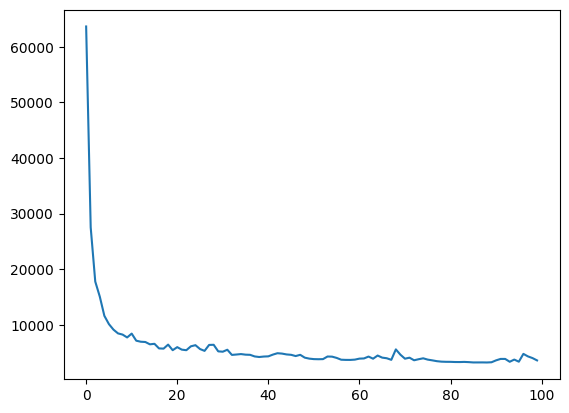

In [13]:

n_epochs = 100
losses, frames = train_model(
  dataloader=dl,
  model=vae_sr,
  n_epochs=n_epochs,
  device=device,
  test_image=test_image,
  lr=1e-3,
  # beta=1.2
)

plt.plot(losses.reshape(n_epochs, -1).mean(axis=1))


# Analysis

## Learning Analysis

### visualize learning

During the training loop the same image was sampled at each batch, now we can take these frames and turn them into a video to visualize the progress

In [14]:
to_vid = np.array(frames)
while to_vid.shape[0] > 500: # limit the video to have max 500 frames
  to_vid = to_vid[::2]

to_vid = (to_vid + 1) / 2
create_video(to_vid, portrait_mode=portrait_mode)

Video shape: (350, 72, 128, 3)


### Sample model for images

In [15]:
def resize_to_size(img, target_size):
    """Resizes the image to the target size using nearest-neighbor (pixelated)."""
    img = img.unsqueeze(0)  # Add batch dimension for F.interpolate
    img = F.interpolate(img, size=target_size, mode='nearest').squeeze(0)  # Nearest-neighbor resizing
    return img


def render_image_matrix(images, titles=None, portrait_mode=False):
    """Render images in a grid (row by row) where each row corresponds to one sample, with titles on top only."""
    # Normalize images from [-1, 1] to [0, 1]
    images = (images + 1) / 2

    # If images are in portrait mode, rotate them
    if portrait_mode:
        images = torch.rot90(images, k=3, dims=[2, 3])

    # Move images to CPU and permute dimensions to (H, W, C)
    images = images.cpu()
    images = np.transpose(images, (0, 2, 3, 1))

    # Calculate number of rows (samples) and columns (ground truth, label, recon)
    num_samples = images.shape[0] // 3  # 3 images per sample (gt, label, recon)

    # Create figure with multiple rows and 3 columns, adjust the spacing between them
    fig, axs = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples), gridspec_kw={'wspace': 0.05, 'hspace': 0.05}, tight_layout=True)

    for i, img in enumerate(images):
        row = i // 3  # Which sample row we are in
        col = i % 3   # Ground truth, label, or reconstruction (3 columns)

        ax = axs[row, col]
        ax.imshow(img)
        if row == 0 and titles and col < len(titles):  # Only set titles for the first row
            ax.set_title(titles[col], fontsize=18, weight='bold')
        ax.axis('off')

    plt.show()


@torch.no_grad()
def sample_images(n, net, images, labels, title_x='gt', title_y='pred', title_y_hat='y_hat', portrait_mode=False):
    net.eval()
    random_indices = np.random.choice(images.shape[0], size=n, replace=False)
    
    # Select the subset of images and labels
    images_subset = images[random_indices]
    labels_subset = labels[random_indices]
    
    # Forward pass with the selected images
    x_recon, _, _ = net(images_subset.to(device))
    x_recon = x_recon.detach().cpu()

    img_matrix = []
    titles_matrix = [title_x, title_y, title_y_hat]  # Titles will appear once, at the top of each column

    for idx in range(n):  # Loop through the subset indices
        # Find the largest image size for resizing
        img_sizes = [
            images_subset[idx].shape[1:], 
            labels_subset[idx].shape[1:], 
            x_recon[idx].shape[1:]
        ]
        max_size = [max(sizes) for sizes in zip(*img_sizes)]

        # Resize all images to the largest size with nearest-neighbor (pixelated) method
        row_images = [
            resize_to_size(images_subset[idx], max_size),
            resize_to_size(labels_subset[idx], max_size),
            resize_to_size(x_recon[idx], max_size)
        ]

        # Add the images of this index to the matrix
        img_matrix.extend(row_images)

    # Render all images in the matrix (side by side in rows)
    render_image_matrix(torch.stack(img_matrix), titles_matrix, portrait_mode=portrait_mode)





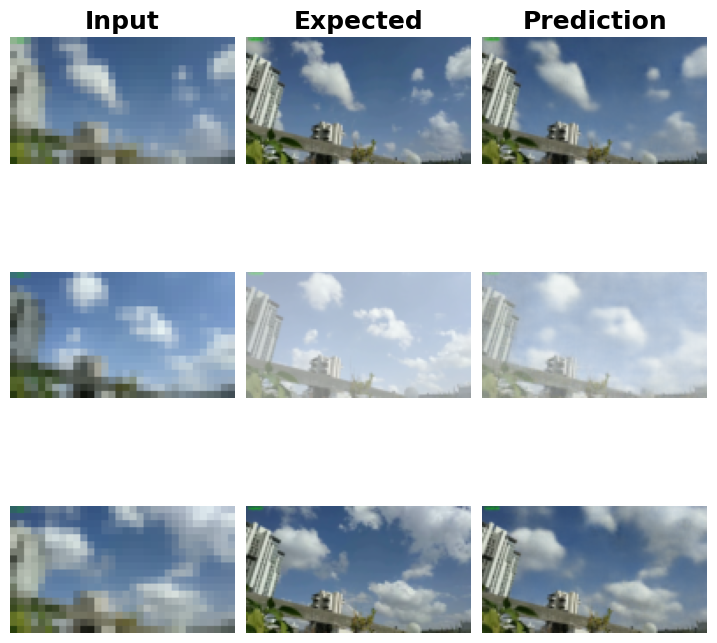

In [16]:

sample_images(
    n=3,
    net=vae_sr,
    images=X_gt,
    labels=y_gt,
    title_x='Input',
    title_y='Expected',
    title_y_hat='Prediction',
    portrait_mode=portrait_mode
)

### Generate images

Time to See What It Learned! we implement a method for generating dynamic image transformations using a random walk approach within the latent space of a Variational Autoencoder (VAE). The defined functions enable us to manipulate the latent representations by applying random directional changes and rotations. The random_walk_image function takes an input image and performs a series of transformations, producing new frames that illustrate the effects of varying directions in the latent space. This technique offers a unique way to visualize the impact of navigating the latent space, showcasing the model's ability to generate diverse outputs from a single input image.

In [17]:
def get_random_direction(logvar):
  std = torch.exp(0.5 * logvar)
  eps = torch.randn_like(std)
  return std * eps

def rotate_2d_tensor(tensor, row_indices, angle):

    cos_theta = torch.cos(angle)
    sin_theta = torch.sin(angle)
    rotation_matrix = torch.tensor([[cos_theta, -sin_theta],
                                    [sin_theta,  cos_theta]])


    rows_to_rotate = tensor[row_indices]
    rotated_rows = torch.matmul(rotation_matrix, rows_to_rotate.T).T
    tensor[row_indices] = rotated_rows

    return tensor

def random_walk_image(img, net, angle, steps, change_prob):
  angle = torch.deg2rad(torch.tensor(angle))
  _, mu, lv = net(img.to(device).unsqueeze(0))
  mu = mu.cpu()
  dir = get_random_direction(lv).cpu().detach().squeeze()
  new_frames = []
  print('Direction', dir)
  row_indices = np.array([0, 1])
  for i in range(steps):
    if np.random.rand() > change_prob:
      row_indices[[1, 0]] = row_indices
      row_indices[1] = torch.randint(0, dir.size(0), (1,)).item()
    n_dir = rotate_2d_tensor(dir, row_indices, angle)
    z = mu + n_dir*5
    pic = net.from_latent(z.to(device))
    pic = pic.squeeze().cpu().detach().numpy()
    new_frames.append((pic + 1) / 2)
  return create_video(new_frames, portrait_mode=portrait_mode)

In [18]:
index = torch.randint(0, X_gt.size(0), (1,)).item()
print('image index', index)

random_walk_image(
    img=X_gt[index],
    net=vae_sr,
    angle=10,
    steps=300,
    change_prob=.5
)

image index 112
Direction tensor([ 5.0137e-03, -5.3190e-01, -1.4701e-01, -4.5437e-01,  8.0245e-05,
         6.1836e-02, -1.4996e-01, -5.1789e-01, -4.5426e-02,  1.9013e-01,
         2.2404e-01,  3.6757e-03,  1.2923e-01,  2.8981e-01, -2.7287e-01,
        -1.8606e-01,  1.1581e-01,  3.4938e-01, -1.7430e-01,  3.4626e-01,
        -3.1636e-04, -5.9517e-02,  9.4606e-02, -2.5210e-01, -1.0963e-01,
         2.4963e-01, -2.5942e-01,  7.9020e-02, -1.0778e-01, -4.9686e-01])
Video shape: (300, 72, 128, 3)


## Latent Space Analysis

In this section, we focus on evaluating the latent space of our Variational Autoencoder (VAE) model through various dimensionality reduction techniques. The evaluate_latent and evaluate_latent_batches functions extract latent representations from the input images without affecting the model's parameters. Once we have these latent vectors, we apply Principal Component Analysis (PCA) to visualize them in both 2D and 3D, providing insight into the structure and distribution of the latent space. Furthermore, we use t-SNE and Isomap to explore the latent representations, showcasing their effectiveness in capturing complex relationships within the data. Additionally, we visualize the correlation matrix of the latent vectors and create scatter and heatmap visualizations to further analyze the latent space, aiding in understanding the model's performance and characteristics.



In [19]:
def evaluate_latent(model, images):
  with torch.no_grad():
    _, latents, _ = model(images.to(device))
    latents_np = latents.cpu().detach().numpy()
  return latents_np

def evaluate_latent_batches(model, images, batches=16):
  result = []
  while len(images) > 0:
    group = images[:batches].to(device)
    e = evaluate_latent(model, group)
    result.append(e)
    images = images[batches:]
  return np.concatenate(result, axis=0)


latents_np = evaluate_latent_batches(vae_sr, X_gt)


### PCA (2D and 3D)

In [20]:
def run_pca(latents_np):
  pca = PCA(n_components=2)
  latent_2d = pca.fit_transform(latents_np)

  plt.figure(figsize=(8, 6))
  plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=range(latents_np.shape[0]), cmap='winter', s=5)
  plt.colorbar()
  plt.title('2D PCA of VAE Latent Space')
  plt.xlabel('PC 1')
  plt.ylabel('PC 2')
  plt.show()

  pca = PCA(n_components=3)
  latent_3d = pca.fit_transform(latents_np)
  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111, projection='3d')

  sc = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=range(latents_np.shape[0]), cmap='winter', s=5)

  cbar = plt.colorbar(sc, ax=ax)
  cbar.set_label('Image number')

  ax.set_title('3D PCA of VAE Latent Space')
  ax.set_xlabel('PC 1')
  ax.set_ylabel('PC 2')
  ax.set_zlabel('PC 3')
  plt.show()


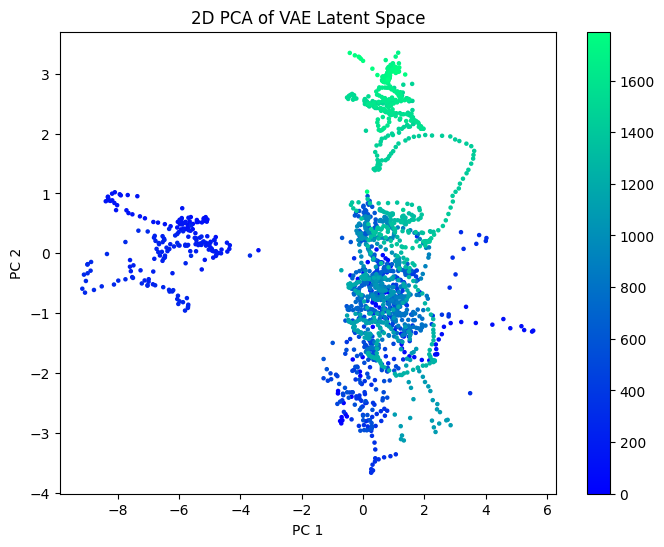

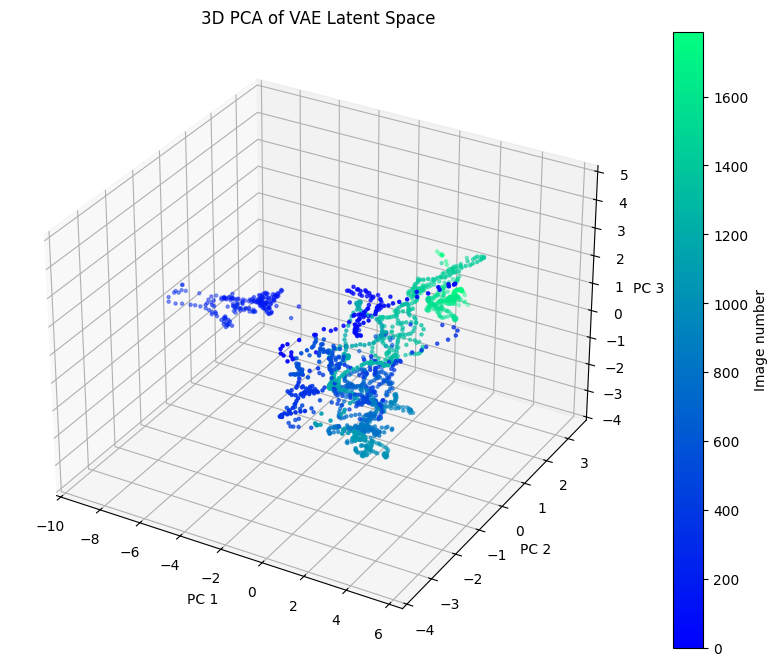

In [21]:
run_pca(latents_np)

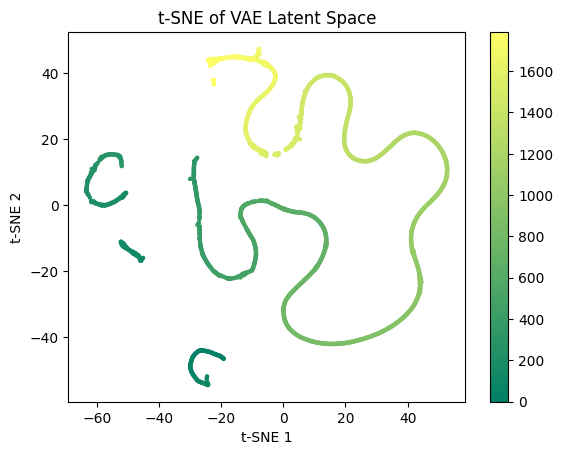

In [22]:

tsne = TSNE(n_components=2, random_state=42)
latent_2d_tsne = tsne.fit_transform(latents_np)

plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=range(latents_np.shape[0]), cmap='summer', s=5)
plt.colorbar()
plt.title('t-SNE of VAE Latent Space')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

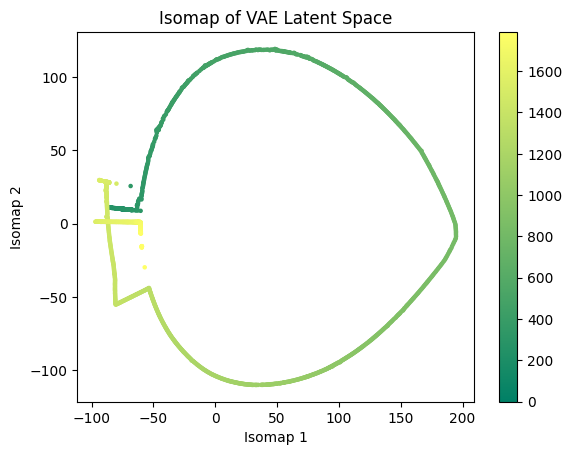

In [23]:

isomap = Isomap(n_components=2, n_neighbors=10)
latent_2d_isomap = isomap.fit_transform(latents_np)

plt.scatter(latent_2d_isomap[:, 0], latent_2d_isomap[:, 1], c=range(latents_np.shape[0]), cmap='summer', s=5)
plt.colorbar()
plt.title('Isomap of VAE Latent Space')
plt.xlabel('Isomap 1')
plt.ylabel('Isomap 2')
plt.show()

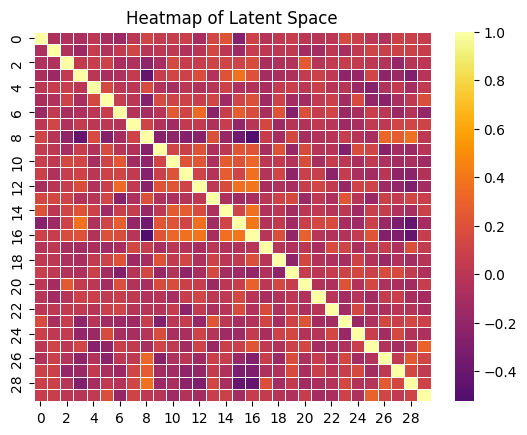

In [24]:
df = pd.DataFrame(latents_np)

# Create a heatmap with the custom color map and annotations
sns.heatmap(df.corr(), center=0, cmap='inferno', #annot=True, fmt=".2f", 
            annot_kws={"size": 8}, linewidths=.5)

# Set the title of the heatmap
plt.title('Heatmap of Latent Space')

# Show the plot
plt.show()


The diagonal suggests that each latent dimension is strongly self correlated, and likely captures unique and independent features from the data.
